# 네이버 검색어 트렌드

## #01. 작업 준비

### 패키지 참조

In [45]:
import requests
import json
from pandas import DataFrame, to_datetime, merge, melt

import sys
sys.path.append("../../")

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

from helper import set_datetime_index, exp_time_data

## #02. 네이버 검색어 트렌드 OpenAPI 연동

### 접속에 필요한 정보 설정

#### API URL

In [46]:
API_URL = "https://openapi.naver.com/v1/datalab/search"

### 발급받은 인증키

In [47]:
client_id = "Nwvd7UzAGjX9l5PMpWev"
client_secret = "LGeBJrCudw"

### 접속 객체 생성

In [48]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
})

### 접속 시도

#### HTTP GET 방식인 경우
'''python
session.get(API_URL, params={"a" : 100, "b" : 200})
'''

#### HTTP POST 방식인 경우

'''python
session.post(API_URL, data={"a" : 100, "b" : 200})
'''

#### HTTP POST 방식이면서 파라미터를 JSON으로 구성하는 경우(body data 전송)

'''python
session.post(API_URL, data=json.dumps({"a" : 100, "b" : 200}))
'''

### 전달할 검색어 구성

In [49]:
data = {
    "startDate": "2022-01-01",   # 2016년 1월 1일부터 조회 시작 가능
    "endDate": "2023-07-31",
    "timeUnit": "date",         # date: 일간, week: 주간, month: 월간
    "keywordGroups": [
        {
            "groupName": "Benz",  # 검색주제
            "keywords": ["e클래스", "s클래스", "c클래스", "벤츠 cls"]   # 주제와 관련된 검색어
        },
         {
            "groupName": "BMW",  # 검색주제
            "keywords": ["5시리즈", "x5", "x7", "x3"]   # 주제와 관련된 검색어
        },
         {
            "groupName": "AUDI",  # 검색주제
            "keywords": ["a6", "e트론", "a7", "q5"]   # 주제와 관련된 검색어
        }
    ]
}

### 데이터 요청하기

In [50]:
r = session.post(API_URL, data=json.dumps(data))

if r.status_code != 200:
    msg = "[%d Error] %s 에러가 발생함" % (r.status_code, r.reason)
    raise Exception(msg)

r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2022-01-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': 'Benz',
   'keywords': ['e클래스', 's클래스', 'c클래스', '벤츠 cls'],
   'data': [{'period': '2022-01-01', 'ratio': 34.18376},
    {'period': '2022-01-02', 'ratio': 35.0223},
    {'period': '2022-01-03', 'ratio': 32.71186},
    {'period': '2022-01-04', 'ratio': 32.33719},
    {'period': '2022-01-05', 'ratio': 32.7297},
    {'period': '2022-01-06', 'ratio': 30.82069},
    {'period': '2022-01-07', 'ratio': 32.40856},
    {'period': '2022-01-08', 'ratio': 35.6289},
    {'period': '2022-01-09', 'ratio': 36.04817},
    {'period': '2022-01-10', 'ratio': 33.2471},
    {'period': '2022-01-11', 'ratio': 30.88314},
    {'period': '2022-01-12', 'ratio': 29.84834},
    {'period': '2022-01-13', 'ratio': 32.39964},
    {'period': '2022-01-14', 'ratio': 31.73059},
    {'period': '2022-01-15', 'ratio': 35.70026},
    {'period': '2022-01-16', 'ratio': 37.43086},
    {'period': '2022-01-17', 'ratio': 31.93577},
    {'

### 응답 결과 구조

In [51]:
print(' 검색결과수 : ',len(mydict['results']))

 검색결과수 :  3


In [52]:
title1 = mydict['results'][0]['title']
print(title1)

data = mydict['results'][0]['data']
df1 = DataFrame(data)
df1.rename(columns={'ratio':title1}, inplace=True)
df1.head()

Benz


,period,Benz
0,2022-01-01,34.18376
1,2022-01-02,35.02230
2,2022-01-03,32.71186
3,2022-01-04,32.33719
4,2022-01-05,32.72970


In [53]:
title2 = mydict['results'][1]['title']
print(title2)

data2 = mydict['results'][1]['data']
df2 = DataFrame(data2)
df2.rename(columns={'ratio':title2}, inplace=True)
df2.head()

BMW


,period,BMW
0,2022-01-01,48.56378
1,2022-01-02,48.85816
2,2022-01-03,45.61106
3,2022-01-04,43.62176
4,2022-01-05,42.33719


In [54]:
title3 = mydict['results'][2]['title']
print(title3)

data3 = mydict['results'][2]['data']
df3 = DataFrame(data3)
df3.rename(columns={'ratio':title3}, inplace=True)
df3.head()

AUDI


,period,AUDI
0,2022-01-01,26.48528
1,2022-01-02,25.17395
2,2022-01-03,26.79750
3,2022-01-04,25.65566
4,2022-01-05,23.84478


### 생성된 데이터프레임 병합

In [55]:
tmp = merge(df1, df2, how='outer')
df = merge(tmp, df3, how='outer')
df.head()

,period,Benz,BMW,AUDI
0,2022-01-01,34.18376,48.56378,26.48528
1,2022-01-02,35.02230,48.85816,25.17395
2,2022-01-03,32.71186,45.61106,26.79750
3,2022-01-04,32.33719,43.62176,25.65566
4,2022-01-05,32.72970,42.33719,23.84478


## #03. 연동 결과에 대한 시계열 분석

### 데이터 타입 확인

In [56]:
df.dtypes

period     object
Benz      float64
BMW       float64
AUDI      float64
dtype: object

### 날짜 컬럼에 대한 형변환 및 인덱스 설정

In [57]:
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df, 'period')
df2

,Benz,BMW,AUDI
2022-01-01,34.18376,48.56378,26.48528
2022-01-02,35.02230,48.85816,25.17395
2022-01-03,32.71186,45.61106,26.79750
2022-01-04,32.33719,43.62176,25.65566
2022-01-05,32.72970,42.33719,23.84478
...,...,...,...
2023-07-27,33.31846,61.78412,17.88581
2023-07-28,36.15521,66.67261,19.30419
2023-07-29,36.05709,67.38626,17.71632
2023-07-30,36.82426,67.67172,16.85994


In [58]:
df3 = df2.reset_index()
df3.head()

,index,Benz,BMW,AUDI
0,2022-01-01,34.18376,48.56378,26.48528
1,2022-01-02,35.02230,48.85816,25.17395
2,2022-01-03,32.71186,45.61106,26.79750
3,2022-01-04,32.33719,43.62176,25.65566
4,2022-01-05,32.72970,42.33719,23.84478


In [59]:
df4 = melt(df3, id_vars=['index'], value_vars=['Benz','BMW','AUDI'], var_name='키워드', value_name='검색량')
df4.set_index('index', inplace=True)
df4.head()

,키워드,검색량
index,,
2022-01-01,Benz,34.18376
2022-01-02,Benz,35.02230
2022-01-03,Benz,32.71186
2022-01-04,Benz,32.33719
2022-01-05,Benz,32.72970


C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 508

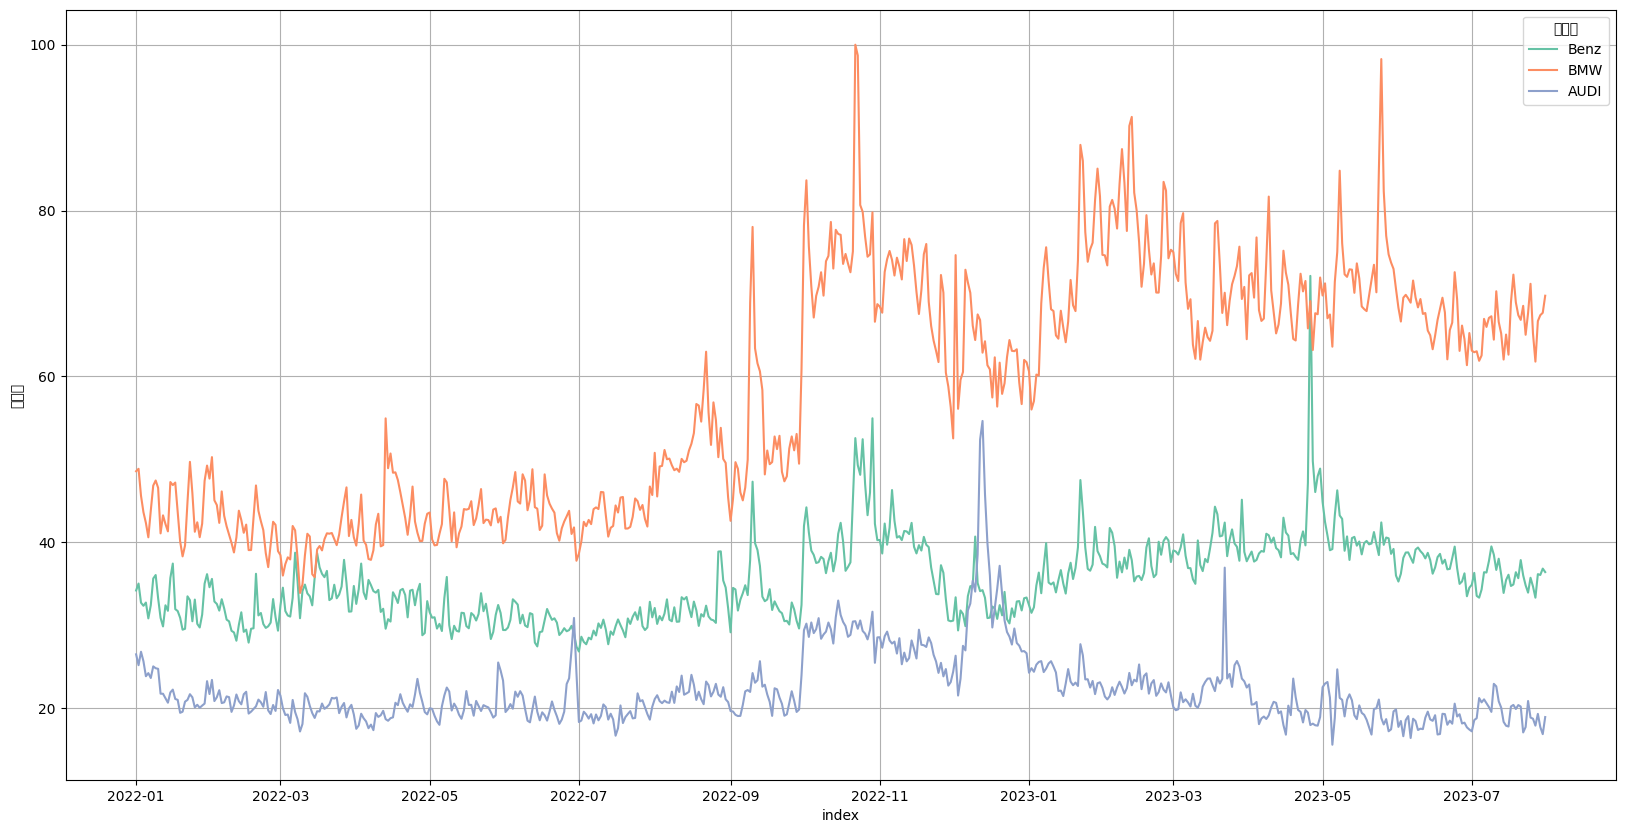

In [60]:
plt.figure(figsize=(20,10))
sb.lineplot(data=df4, y='검색량', x=df4.index, hue='키워드', palette='Set2')
plt.grid()
plt.show()
plt.close()

### helper에 구현된 기능을 활용하여 데이터 검정

Benz
결측치 수 : 0


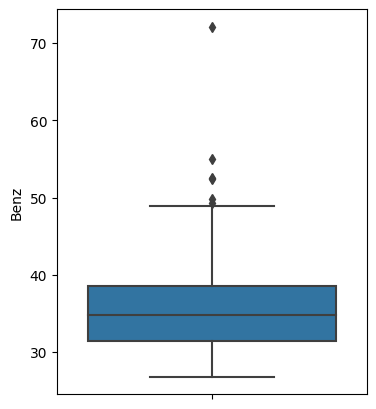

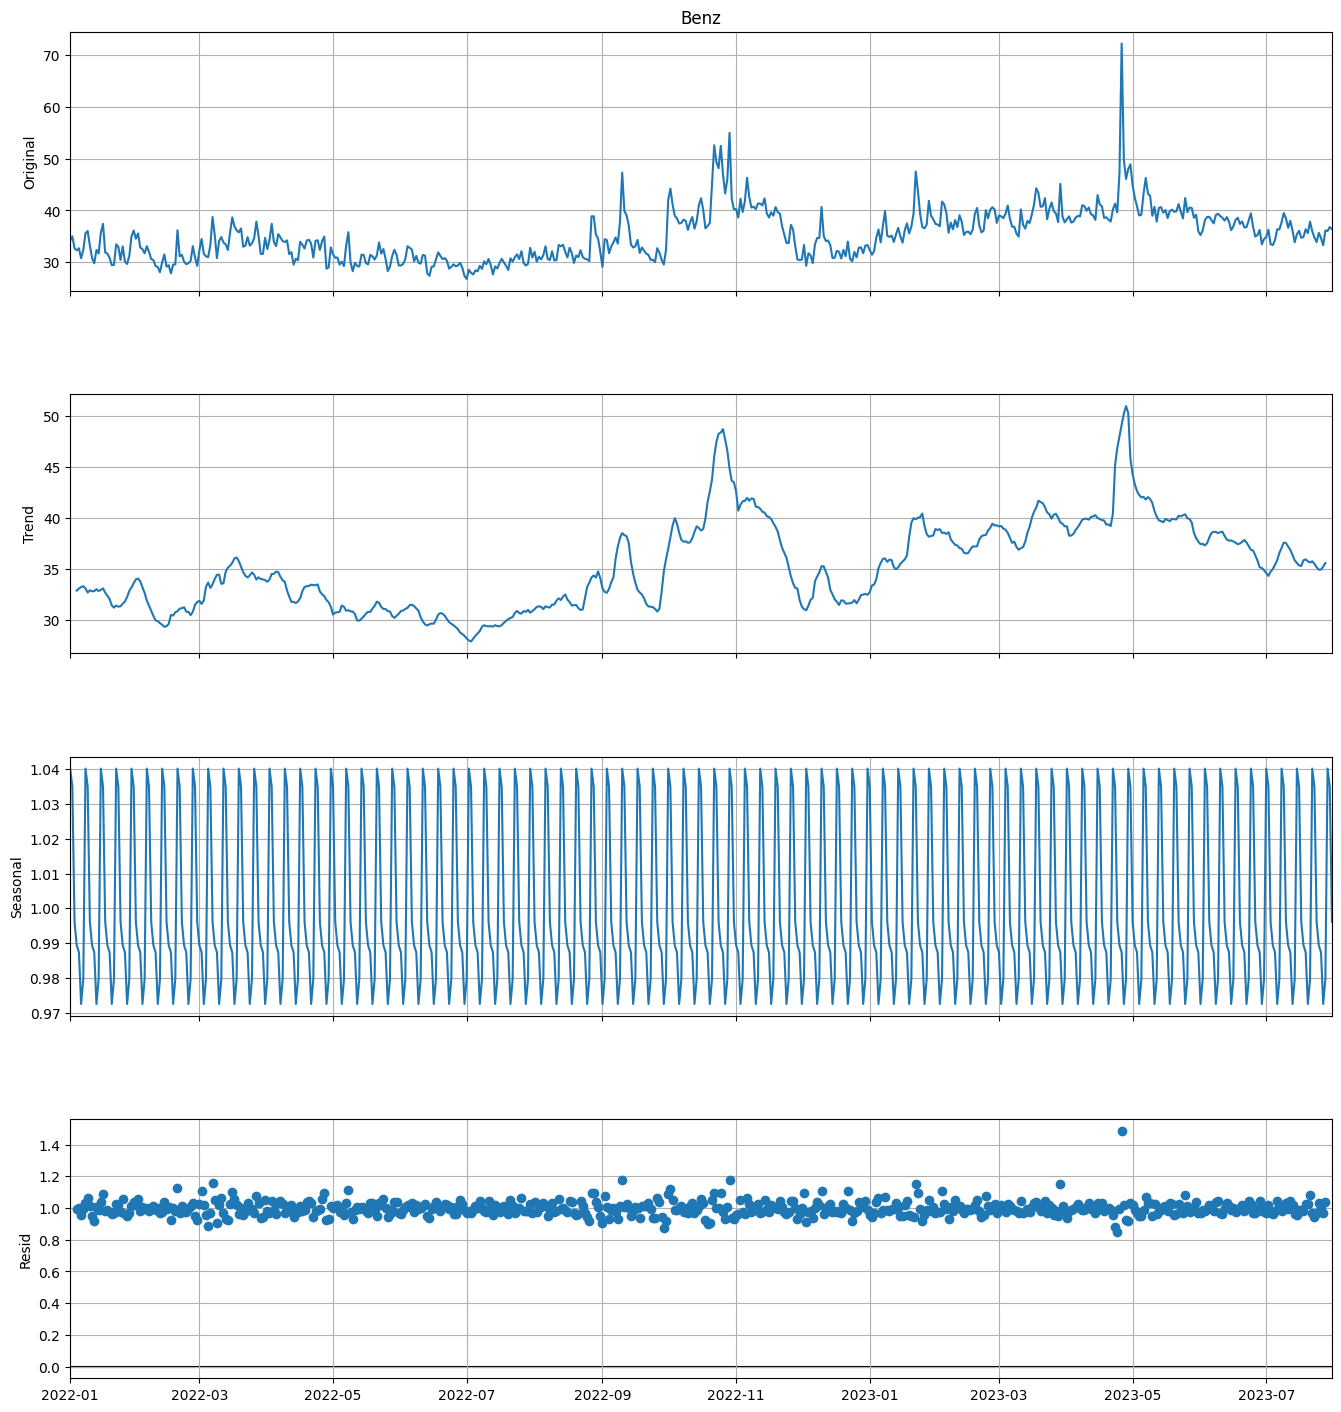

========= 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -2.18379 |
| 유의수준(p-value)                  | 0.212181 |
| 최적차수(num of lags)              |       12 |
| 관측치 개수(num of observations)   |      564 |
| 기각값(Critical Values) 1%         |   -3.442 |
| 기각값(Critical Values) 5%         | -2.86668 |
| 기각값(Critical Values) 10%        | -2.56951 |
| 데이터 정상성 여부(0=False,1=True) |        0 |
+------------------------------------+----------+


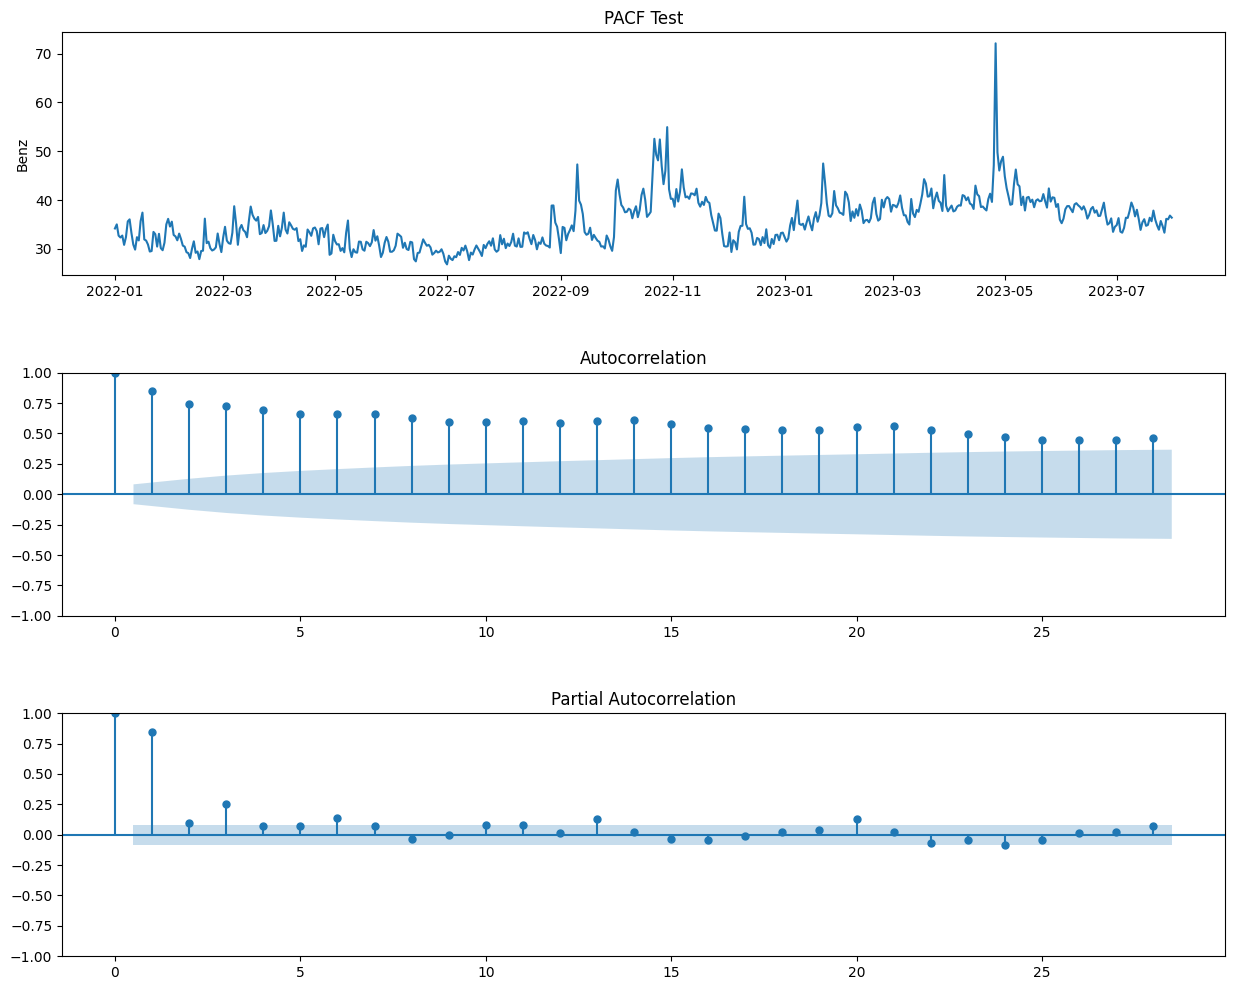

========= 1차 차분 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -8.08036 |
| 유의수준(p-value)                  | 1.46706e-12 |
| 최적차수(num of lags)              |          18 |
| 관측치 개수(num of observations)   |         557 |
| 기각값(Critical Values) 1%         |    -3.44214 |
| 기각값(Critical Values) 5%         |    -2.86674 |
| 기각값(Critical Values) 10%        |    -2.56954 |
| 데이터 정상성 여부(0=False,1=True) |           1 |
+------------------------------------+-------------+


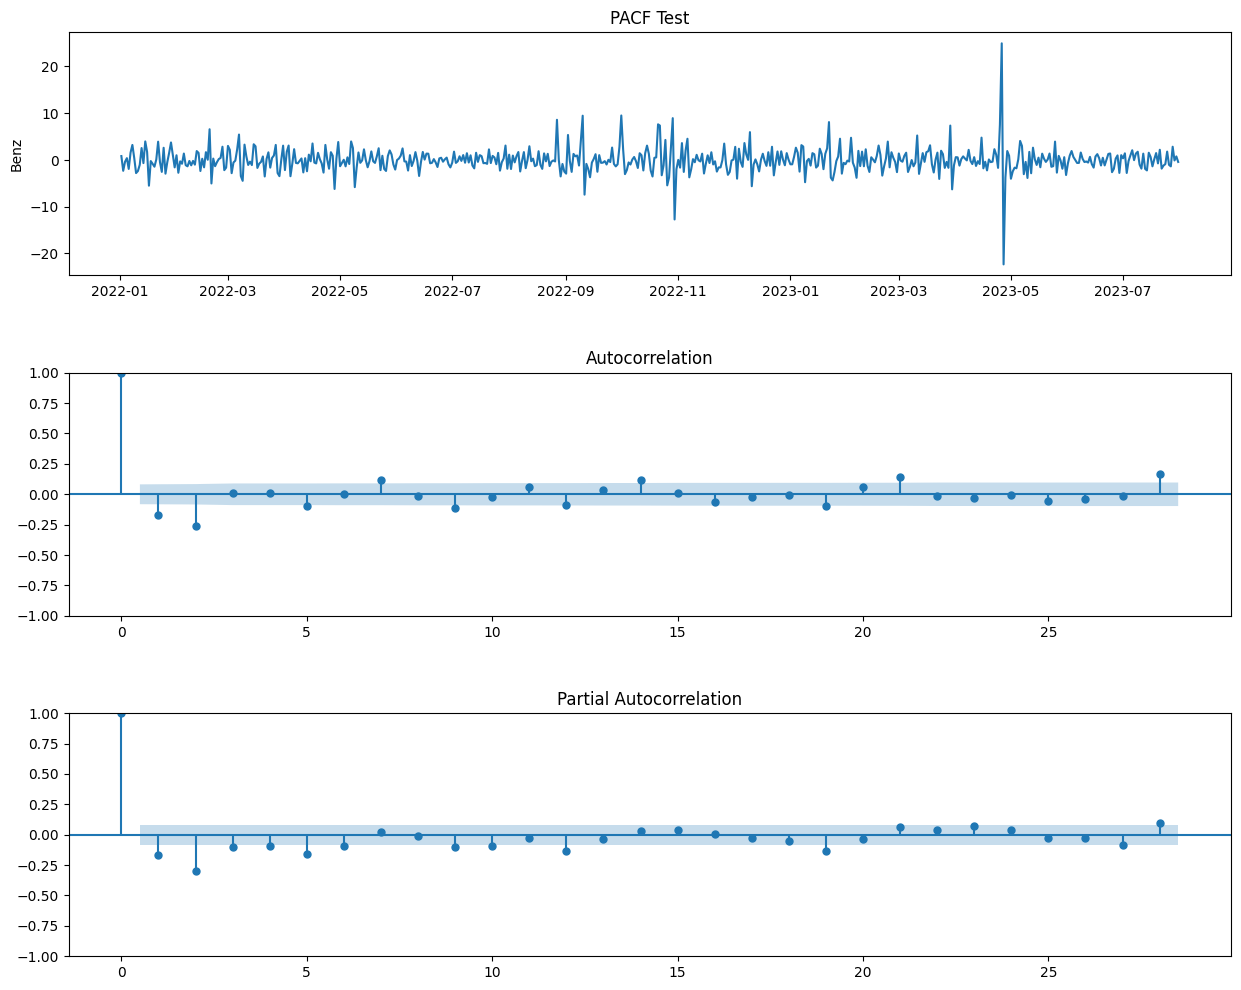

BMW
결측치 수 : 0


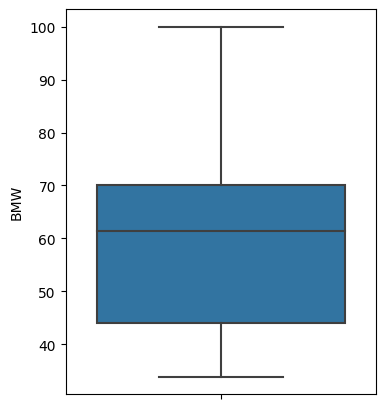

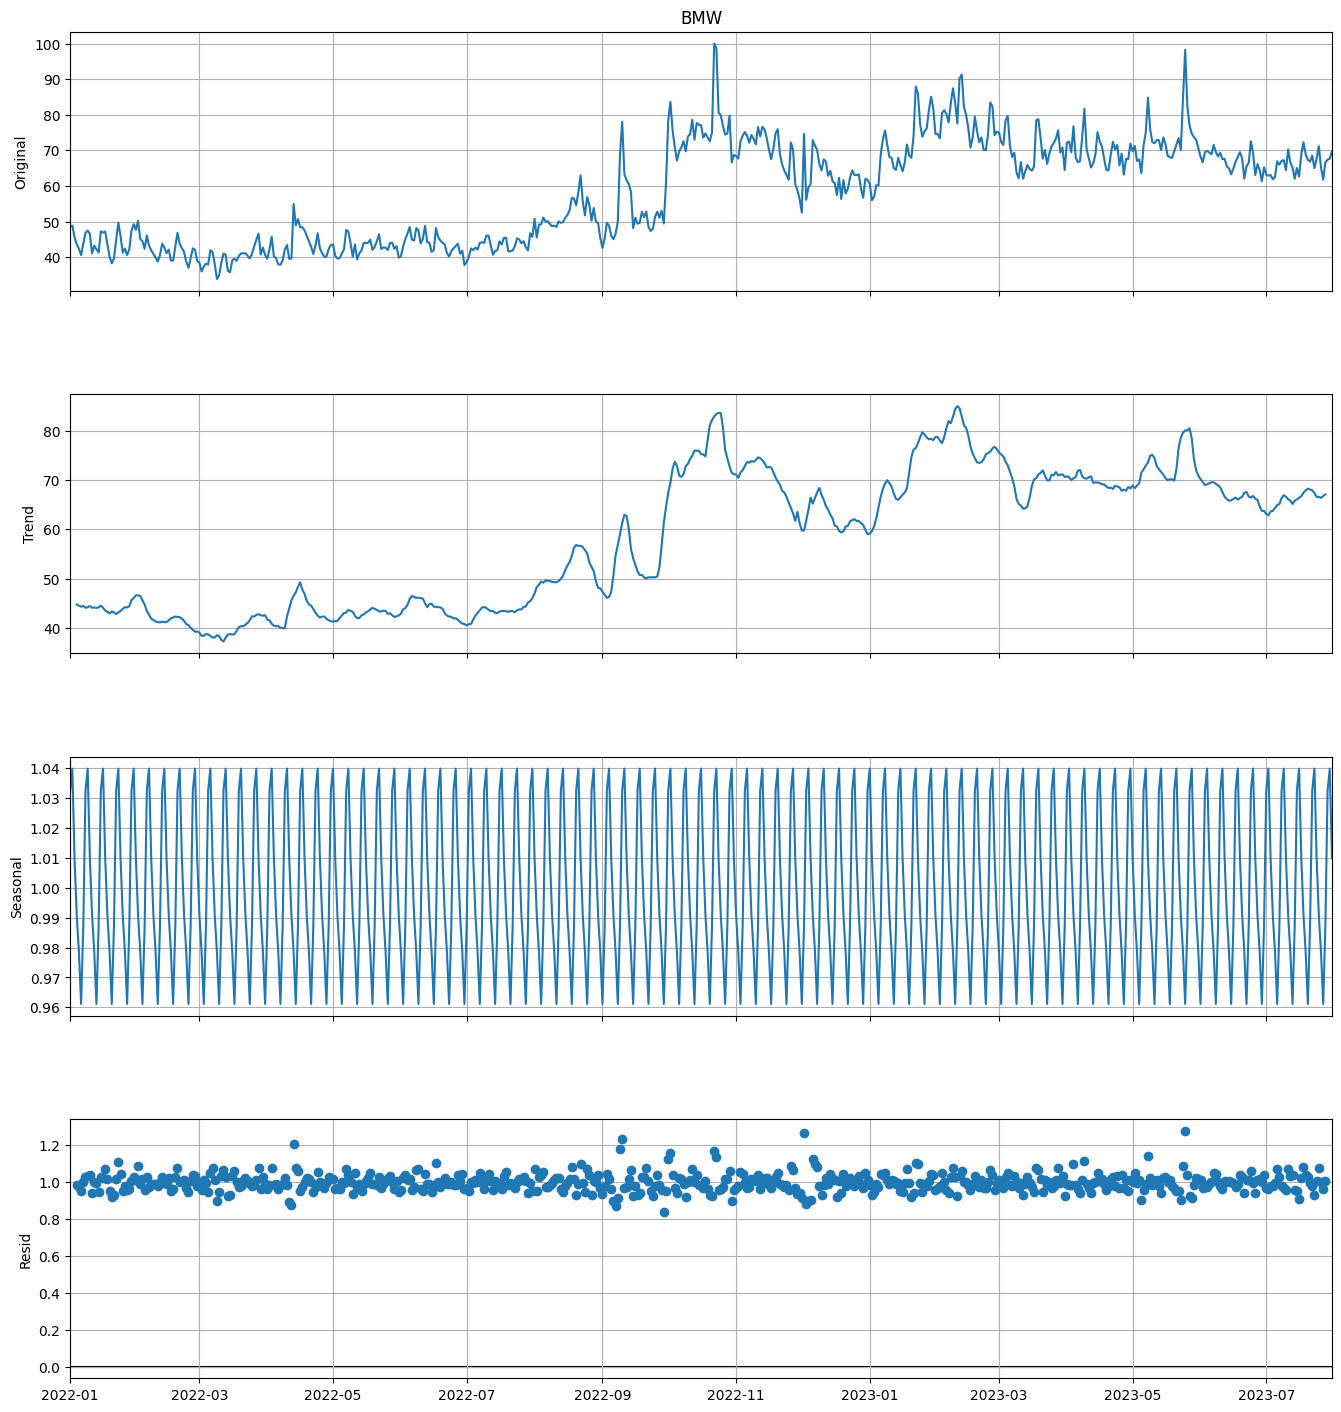

========= 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -1.31753 |
| 유의수준(p-value)                  | 0.621116 |
| 최적차수(num of lags)              |       13 |
| 관측치 개수(num of observations)   |      563 |
| 기각값(Critical Values) 1%         | -3.44202 |
| 기각값(Critical Values) 5%         | -2.86669 |
| 기각값(Critical Values) 10%        | -2.56951 |
| 데이터 정상성 여부(0=False,1=True) |        0 |
+------------------------------------+----------+


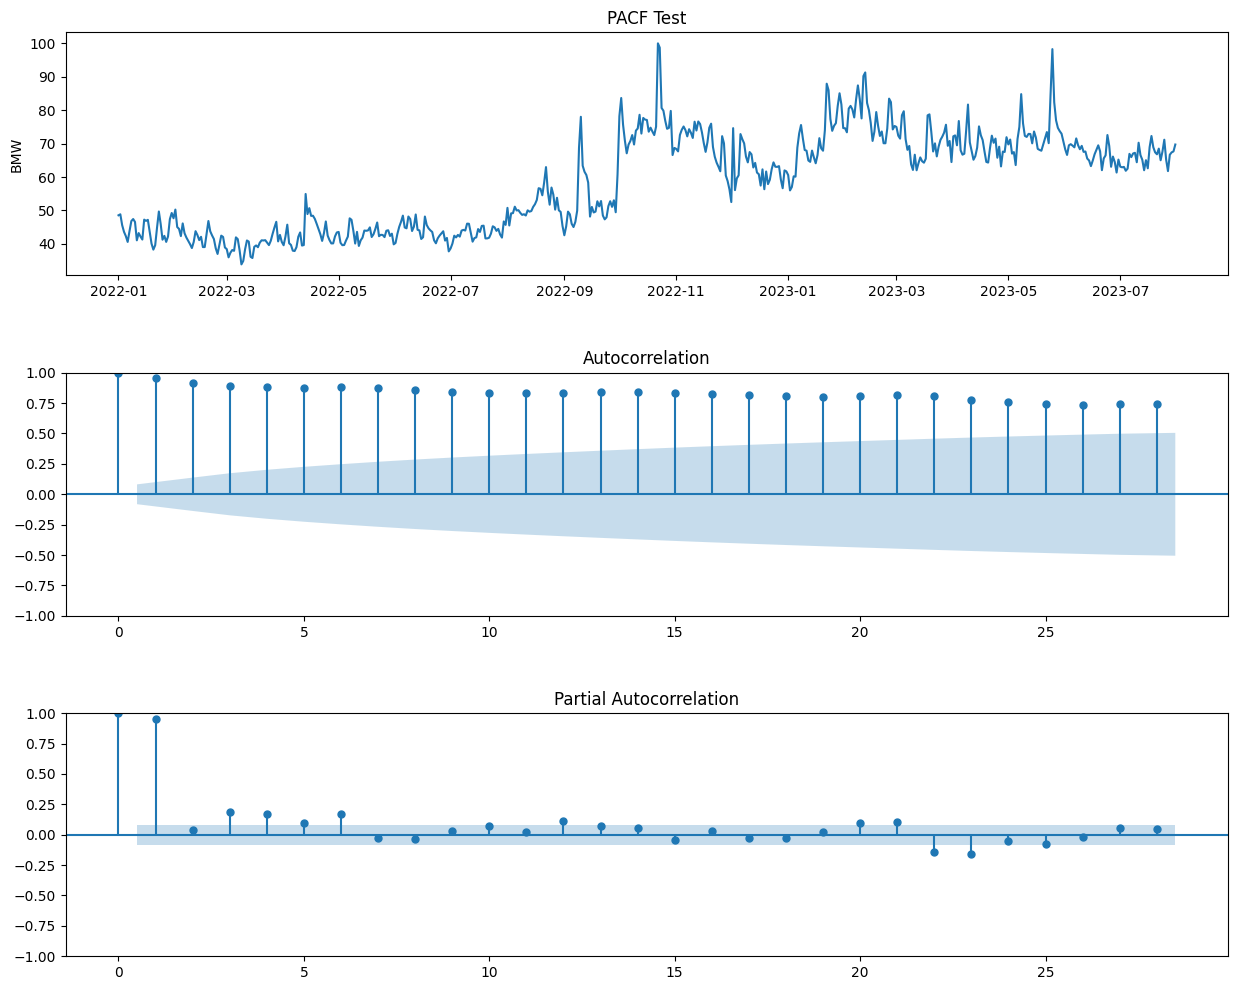

========= 1차 차분 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -8.33751 |
| 유의수준(p-value)                  | 3.24229e-13 |
| 최적차수(num of lags)              |          19 |
| 관측치 개수(num of observations)   |         556 |
| 기각값(Critical Values) 1%         |    -3.44217 |
| 기각값(Critical Values) 5%         |    -2.86675 |
| 기각값(Critical Values) 10%        |    -2.56955 |
| 데이터 정상성 여부(0=False,1=True) |           1 |
+------------------------------------+-------------+


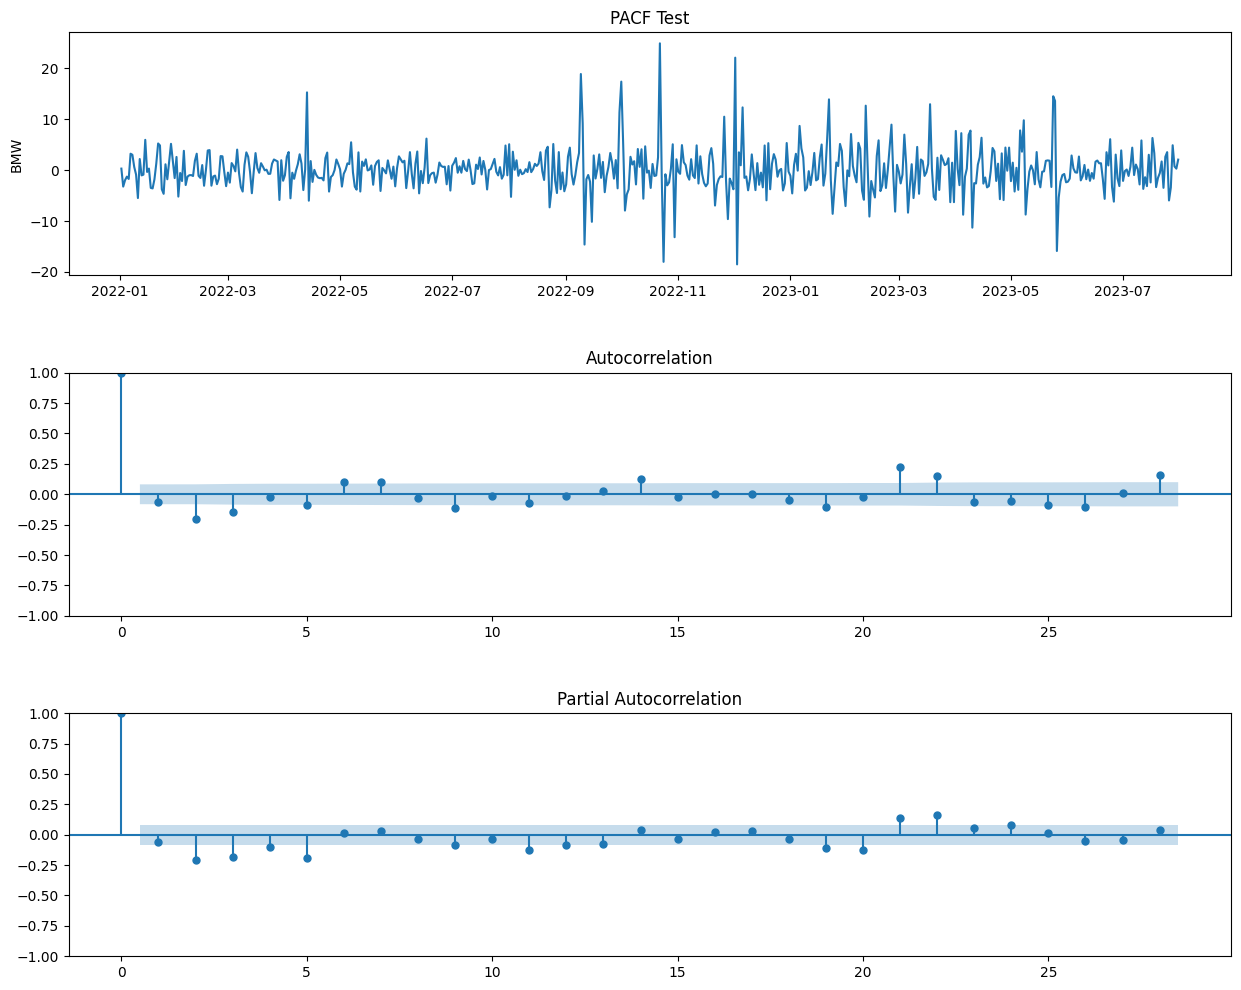

AUDI
결측치 수 : 0


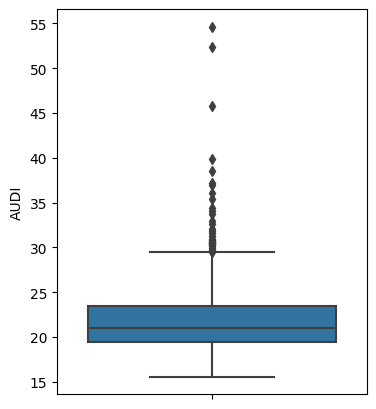

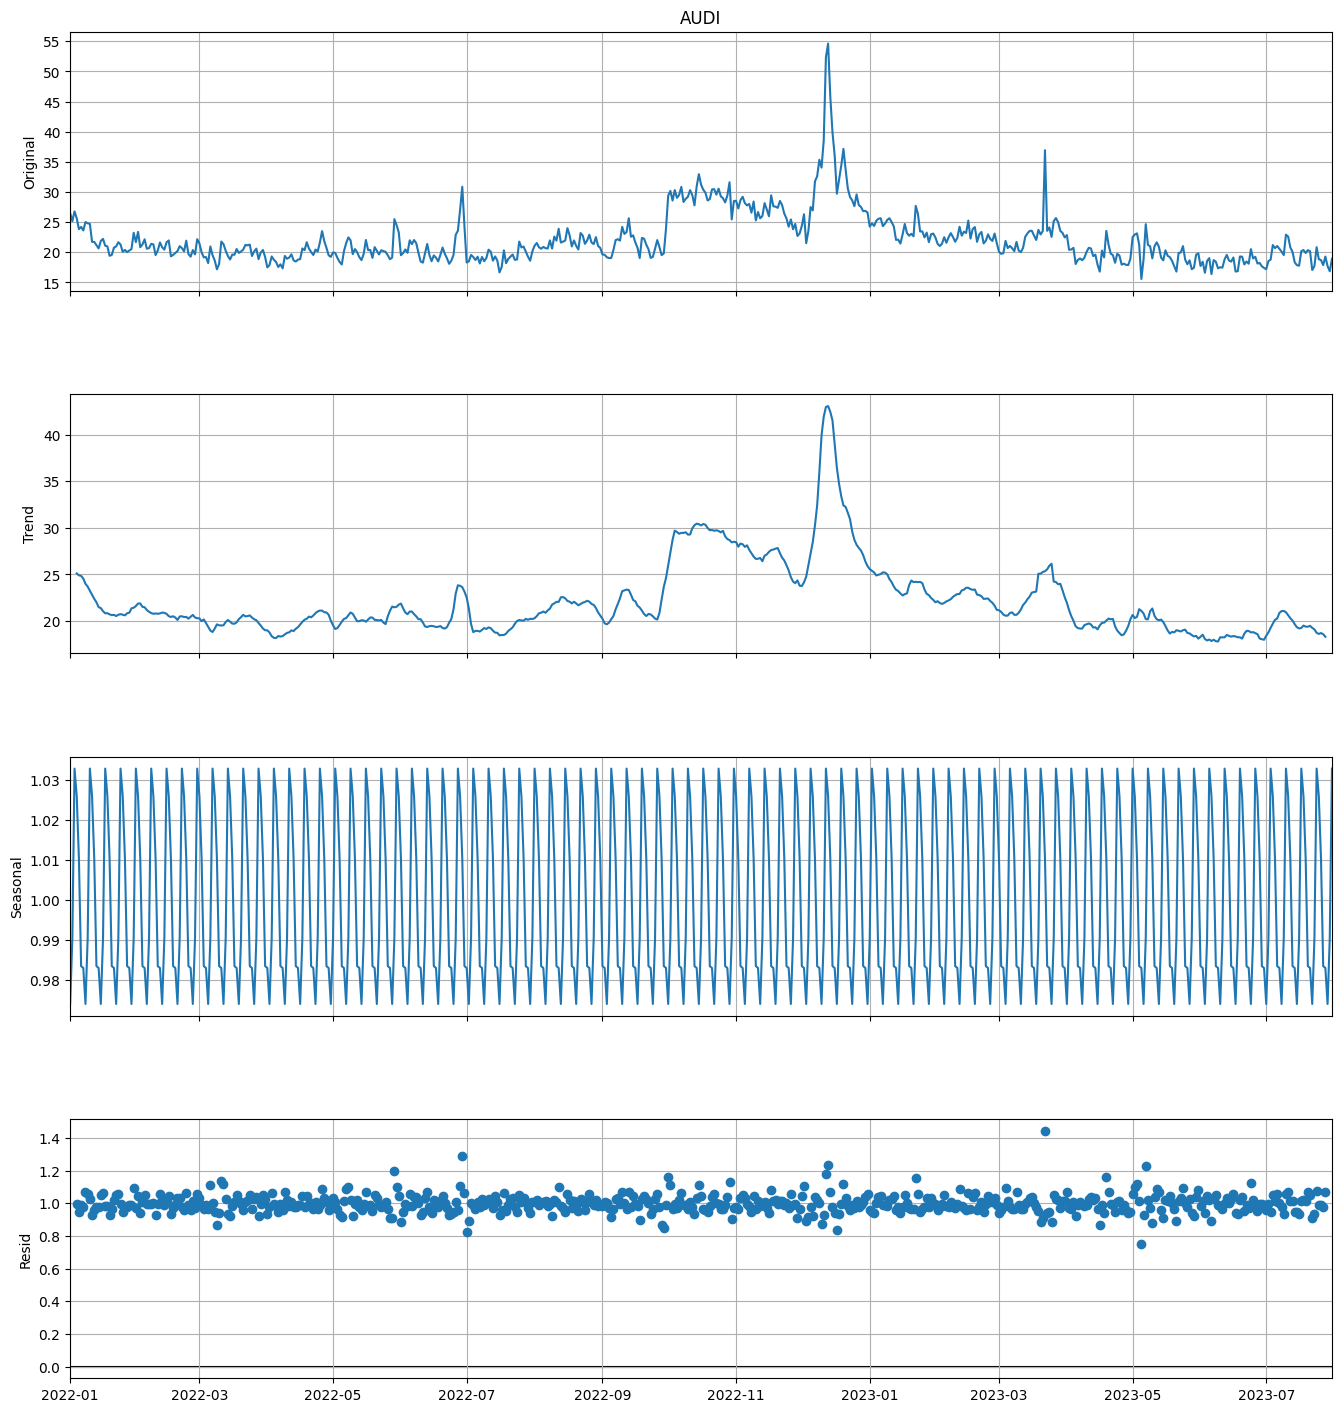

========= 원본 데이터 ===========
+------------------------------------+------------+
| ADF Test                           |            |
|------------------------------------+------------|
| 검정통계량(ADF Statistic)          |   -3.43624 |
| 유의수준(p-value)                  | 0.00978373 |
| 최적차수(num of lags)              |          4 |
| 관측치 개수(num of observations)   |        572 |
| 기각값(Critical Values) 1%         |   -3.44183 |
| 기각값(Critical Values) 5%         |   -2.86661 |
| 기각값(Critical Values) 10%        |   -2.56947 |
| 데이터 정상성 여부(0=False,1=True) |          1 |
+------------------------------------+------------+


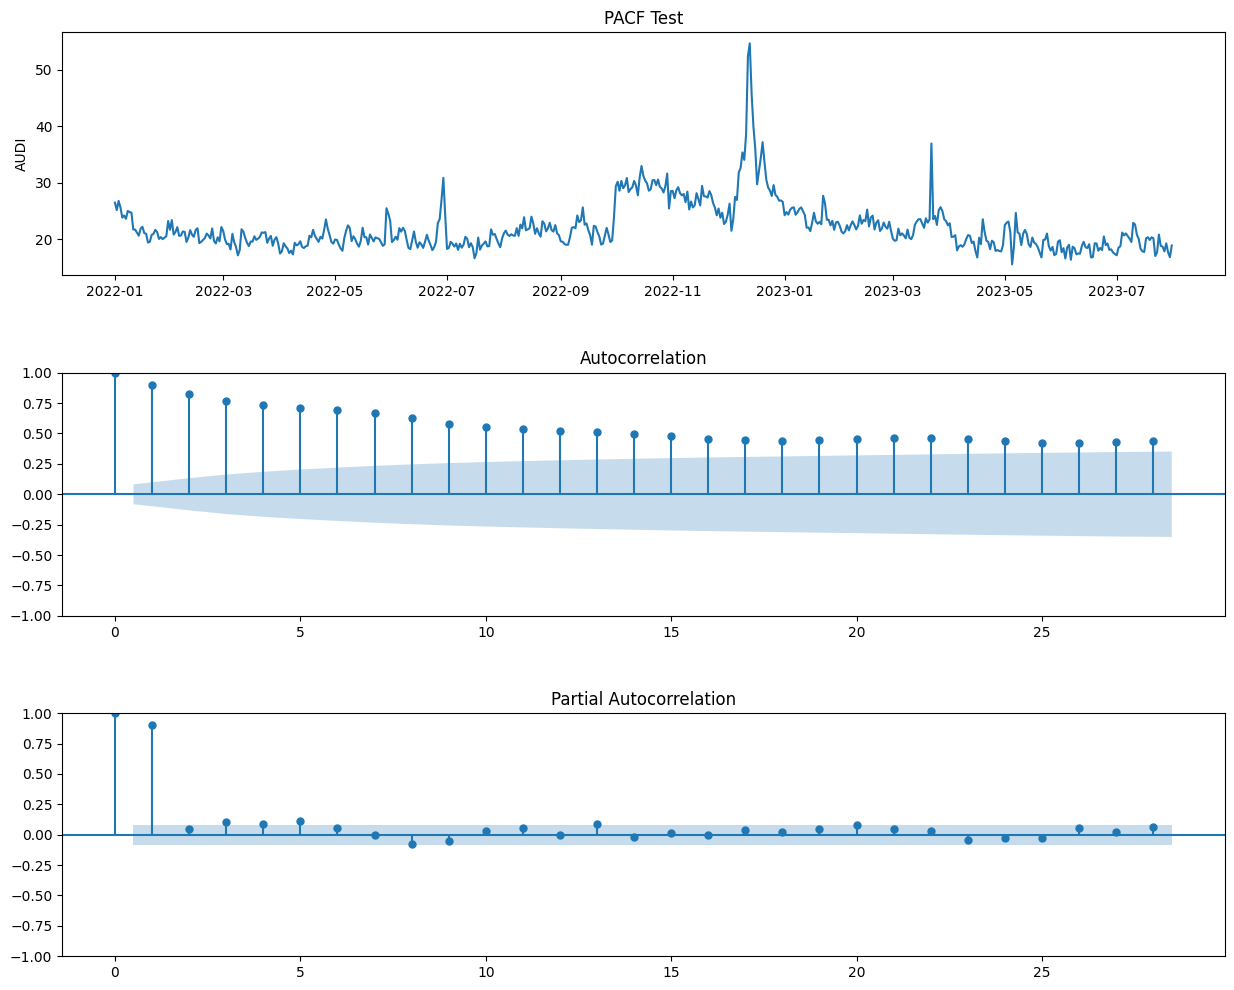

In [61]:
for c in df2.columns:
    print("====================")
    print(c)
    print("====================")

    exp_time_data(df2, c, 'm', max_diff=10)

### ARIMA 분석수행

분석모델구성

In [62]:
pdq = (
    ((1,0,0),(1,0,0,7)), #0번째
    ((1,1,0),(1,1,0,7)), #1번째
    ((1,1,0),(1,1,0,7))  #2번쩨
)

C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4704

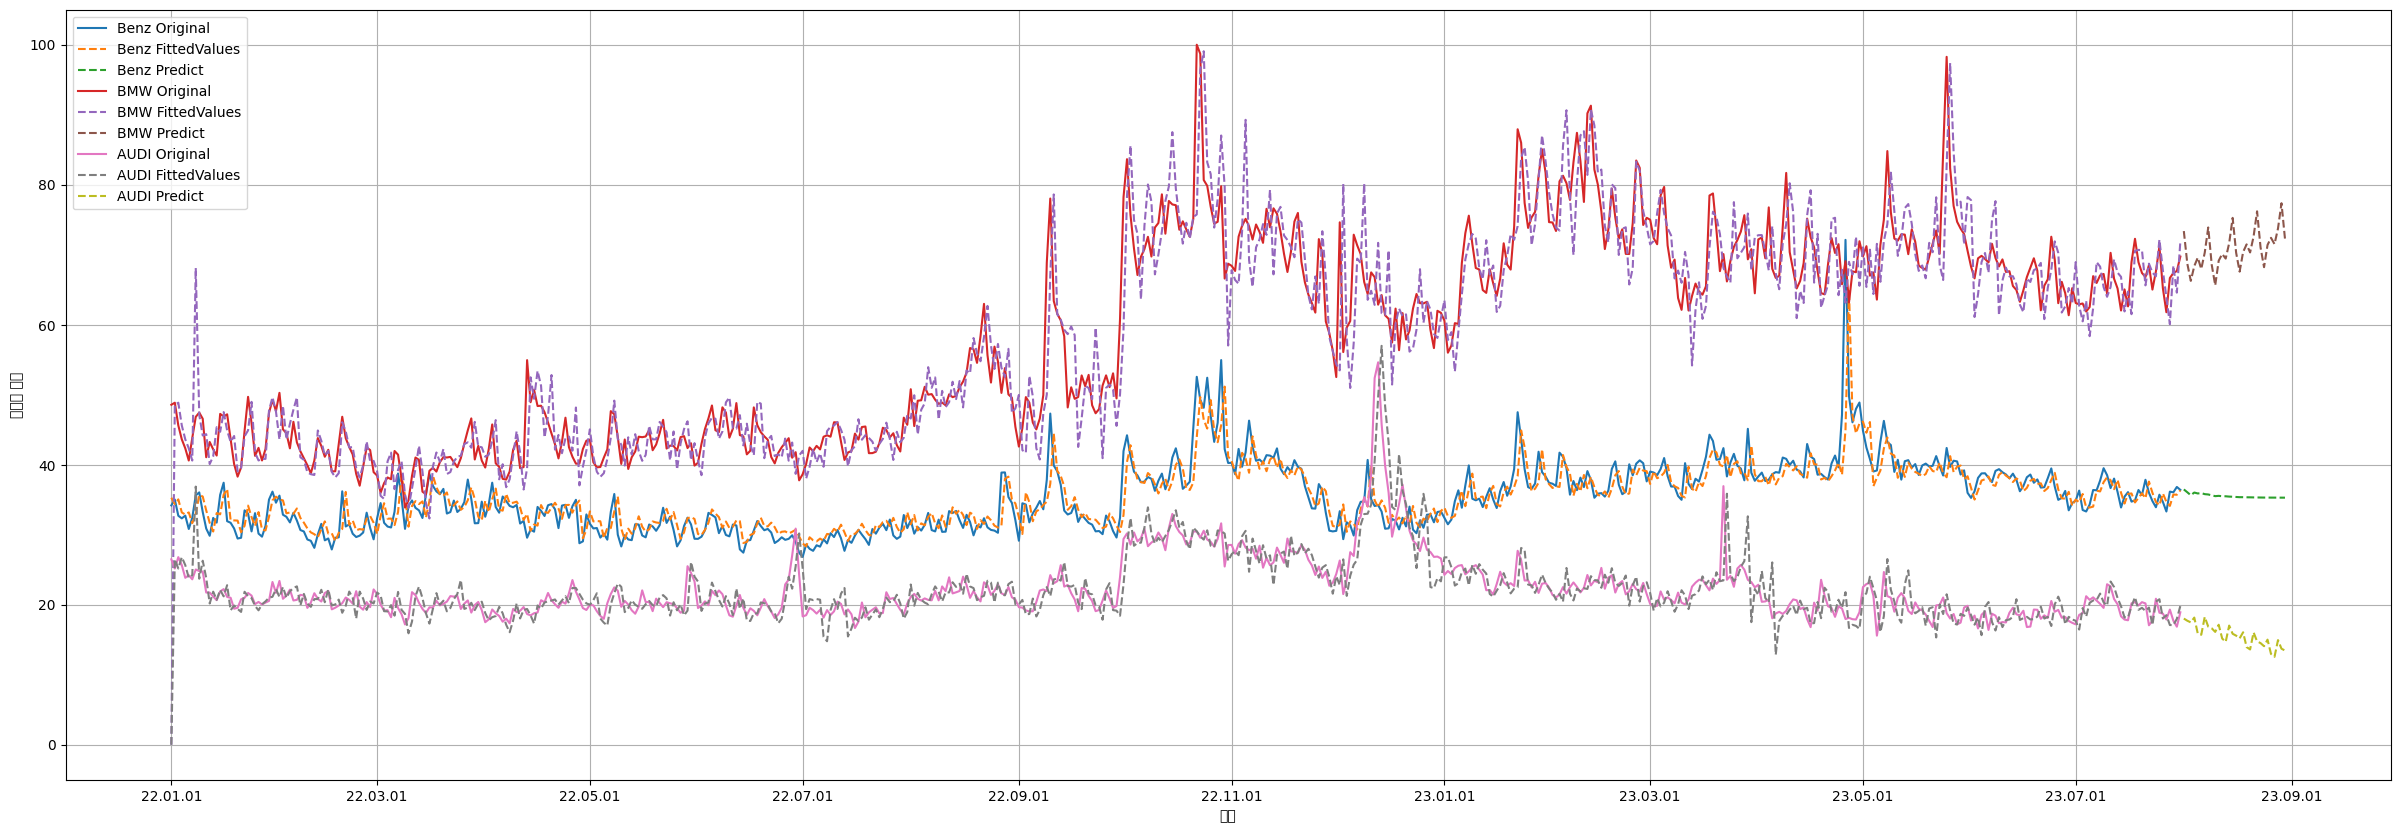

In [63]:
plt.figure(figsize=(30,10))

for i,c in enumerate(df2.columns):
    # 모델 구성
    model = ARIMA(df2[c], order=pdq[i][0], seasonal_order=pdq[i][1])
    fit = model.fit()
    # 학습결과
    fv = fit.fittedvalues
    # 예측값
    fc = fit.forecast(30)

    sb.lineplot(data=df2, x=df2.index, y=c, label='%s Original' % c)
    sb.lineplot(x=fv.index, y=fv.values, label='%s FittedValues'% c, linestyle='--')
    sb.lineplot(x=fc.index, y=fc.values, label='%s Predict' % c, linestyle='--')

plt.xlabel('날짜')
plt.ylabel('검색량 비율')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()